##### 기본 설정

In [32]:
import os
import warnings
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from pprint import pprint
from textwrap import dedent

# 환경설정
load_dotenv()
warnings.filterwarnings("ignore") # 파이썬 경고 무시

#### 문제 7-1 : LangGraph ReAct Agent 실습 연습문제 (Vector DB + Tool 연동)  
- 사용자 정의 ReAct Agent 구현 (조건부 엣지 활용) 

1. db tool 설정

In [33]:
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# menu db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> str:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=6)

    if not docs:
        return "관련 메뉴 정보를 찾을 수 없습니다."

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata.get("source", "unknown")}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    return "관련 카페 메뉴 정보를 찾을 수 없습니다."


# 2단계: 상태 정의  
class AgentState(MessagesState):
        """ReAct Agent의 상태를 정의하는 클래스"""
        pass


2. llm 설정 및 tool 연결

In [34]:
# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_menu]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
#print(type(llm_with_tools))

gpt-4o-mini


##### 1차 테스트

In [35]:
tool_call = llm_with_tools.invoke("아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")
#pprint(tool_call.additional_kwargs)
pprint(tool_call)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_pzWJ6X41projWTRoyEyPHL7a', 'function': {'arguments': '{"query": "아메리카노"}', 'name': 'search_menu'}, 'type': 'function'}, {'index': 1, 'id': 'call_sPpJ9i88QObsVkleddntan9s', 'function': {'arguments': '{"query": "아이스 아메리카노"}', 'name': 'search_menu'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--788a16d5-fce6-434f-9f88-68fe8ea6e735-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '아메리카노'}, 'id': 'call_pzWJ6X41projWTRoyEyPHL7a', 'type': 'tool_call'}, {'name': 'search_menu', 'args': {'query': '아이스 아메리카노'}, 'id': 'call_sPpJ9i88QObsVkleddntan9s', 'type': 'tool_call'}])


3. ReAct agent 사용

In [36]:
# from IPython.display import Image, display
# from langgraph.prebuilt import create_react_agent  # 미리 정의된 에이전트 생성 함수

# graph = create_react_agent(
#     llm, 
#     tools=tools, 
# )
# print(type(graph))

# 그래프 출력
#display(Image(graph.get_graph().draw_mermaid_png()))

- SystemMessage에 넣을 시스템 프롬프트 설정해주기

In [37]:
# 시스템 프롬프트
system_prompt = dedent("""
당신은 카페의 AI 어시스턴트입니다.
사용자의 메뉴 관련 질문에 정확하고 친절하게 답변해주세요.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.
                       
- search_cafe_menu: 카페 메뉴 정보를 검색할 때 사용하세요

고객의 질문을 이해하고, 필요한 경우 도구를 사용하여 정보를 찾은 후 정확한 답변을 제공하세요.
""")

#### 카페 메뉴 검색용 도구 함수

In [38]:
# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 함수 정의 : 도구 필요 응답
# llm_with_tools에 invoke
def call_model(state: GraphState):
    print("--- Agent 노드: LLM 호출 ---")

    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)

    print(f"LLM 응답 생성 완료. 도구 호출 여부: {bool(response.tool_calls)}")
    return {"messages": [response]}

사용자 정의 ReAct Agent가 성공적으로 생성되었습니다!
Agent 타입: <class 'langgraph.graph.state.CompiledStateGraph'>


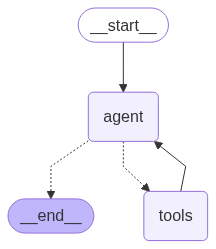

In [39]:
# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools)) # toolNode에 invoke

builder.add_edge(START, "agent")

# tools_condition 사용 - 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition, # 도구 or END로 라우팅
)
builder.add_edge("tools", "agent")

graph = builder.compile()


print("사용자 정의 ReAct Agent가 성공적으로 생성되었습니다!")
print(f"Agent 타입: {type(graph)}")

# 그래프 출력
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("그래프 시각화를 할 수 없습니다.")

In [40]:
# 테스트 함수
def test_custom_react_agent():
    """사용자 정의 ReAct Agent 테스트"""
    test_questions = [
        "아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.",
        "라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?",
        "디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요."
    ]
    
    for question in test_questions:
        print(f"\n{'='*60}")
        print(f"질문: {question}")
        print('='*60)
        
        # Agent 실행
        inputs = {"messages": [HumanMessage(content=question)]}
        result = graph.invoke(inputs)
        
        # 실행 과정 출력
        print("\n=== 실행 과정 ===")
        for i, message in enumerate(result['messages']):
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"{i+1}. {type(message).__name__}: 도구 호출 - {message.tool_calls[0]['name']}")
            else:
                content_preview = message.content[:100] + "..." if len(message.content) > 100 else message.content
                print(f"{i+1}. {type(message).__name__}: {content_preview}")
        
        # 최종 답변 출력
        print(f"\n=== 최종 답변 ===")
        print(result['messages'][-1].content)

In [41]:
# 10단계: 단일 테스트 실행
print("\n=== 단일 테스트 ===")
inputs = {"messages": [HumanMessage(content="콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?")]}
result = graph.invoke(inputs)

print("\n=== 메시지 흐름 분석 ===")
for i, message in enumerate(result['messages']):
    print(f"{i+1}. {type(message).__name__}")
    if hasattr(message, 'tool_calls') and message.tool_calls:
        print(f"   - 도구 호출: {message.tool_calls[0]['name']} with '{message.tool_calls[0]['args']['query']}'")
    else:
        content_preview = message.content[:150] + "..." if len(message.content) > 150 else message.content
        print(f"   - 내용: {content_preview}")

print(f"\n=== 최종 답변 ===")
print(result['messages'][-1].content)

# 11단계: 전체 테스트 실행
print("\n=== 전체 테스트 실행 ===")
test_custom_react_agent()


=== 단일 테스트 ===
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

=== 메시지 흐름 분석 ===
1. HumanMessage
   - 내용: 콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?
2. AIMessage
   - 내용: 콜드브루와 아이스 아메리카노는 모두 차가운 커피 음료이지만, 준비 방법과 맛에서 차이가 있습니다.

1. **콜드브루**: 
   - 원두를 차가운 물에 오랜 시간(보통 12-24시간) 우려내서 만드는 커피입니다. 
   - 일반적으로 부드럽고, 산미가 적으며, 풍부한...

=== 최종 답변 ===
콜드브루와 아이스 아메리카노는 모두 차가운 커피 음료이지만, 준비 방법과 맛에서 차이가 있습니다.

1. **콜드브루**: 
   - 원두를 차가운 물에 오랜 시간(보통 12-24시간) 우려내서 만드는 커피입니다. 
   - 일반적으로 부드럽고, 산미가 적으며, 풍부한 맛을 가지고 있습니다.

2. **아이스 아메리카노**: 
   - 에스프레소 샷을 찬물에 희석하여 만드는 음료입니다. 일반적으로 에스프레소와 물의 비율에 따라 농도가 다를 수 있습니다.
   - 커피의 쌉쌀한 맛이 더 두드러지며, 에스프레소 특유의 깊은 맛이 느껴집니다.

결론적으로, 콜드브루는 침출 방식으로 제조되어 부드럽고 산미가 낮고, 아이스 아메리카노는 에스프레소를 물에 섞어 만든 음료로 풍부한 커피 맛이 강조됩니다.

=== 전체 테스트 실행 ===

질문: 아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

=== 실행 과정 ===
1. HumanMessage: 아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
2. AIMessage: 도구 호출 - search_menu
3. Too

- graph 실행

In [42]:
# 초기 상태: 사용자 입력을 messages 리스트에 넣어서 전달
user_query = input("무엇을 도와드릴까요? ")

# LangGraph에 넘길 상태 정의 (항상 dict 형태여야 함)
initial_state = {
    "messages": [{"role": "user", "content": user_query}]
}

# LangGraph 실행
final_state = graph.invoke(initial_state)

# 마지막 메시지 출력
last_message = final_state["messages"][-1]
print("\nAI 응답:", last_message.content)

--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

AI 응답: 현재 제공된 메뉴에는 케이크에 대한 정보가 포함되어 있지 않습니다. 대신 디저트 메뉴 중에서 '티라미수'를 소개해 드리겠습니다.

### 티라미수
- **가격**: ₩7,500
- **주요 원료**: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
- **설명**: 이탈리아 전통 디저트인 티라미수는 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만든 것입니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.

케이크와 관련된 메뉴가 필요하시다면, 추가로 확인해보거나 다른 문의 사항이 있으면 말씀해 주세요!
